In [139]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import matplotlib
import scipy

In [140]:
host = '130.130.221.71'
user = 'bjb997'
passwd = 'password'
db_name = 'Desert_Rose_House'

In [141]:
def get_thermal(start_date, end_date):
    db_connection_str = f'mysql+pymysql://{user}:{passwd}@{host}/{db_name}'
    db_connection = create_engine(db_connection_str)
    
    df_thermal = pd.read_sql(f'SELECT * from thermal_comfort where date_ between "{start_date}" and "{end_date}";', con=db_connection)
    df_thermal.index = df_thermal.apply(lambda x : datetime.datetime.combine(x['date_'], datetime.time.min) + x['time_'], axis=1)
    
    df_electrical = pd.read_sql(f'SELECT * from electrical_loads where date_ between "{start_date}" and "{end_date}";', con=db_connection)
    df_electrical.index = df_electrical.apply(lambda x : datetime.datetime.combine(x['date_'], datetime.time.min) + x['time_'], axis=1)
    
    df_thermal['t_av'] = (df_thermal['t_bed'] + df_thermal['t_std'] + df_thermal['t_liv'] + df_thermal['t_din'])/4
    df_thermal['power'] = df_electrical['power_1'] + df_electrical['power_2'] + df_electrical['power_3']
    
    return df_thermal

In [142]:
sns.set(font_scale=1.35)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
matplotlib.rcParams['font.family'] = 'Abyssinica SIL'

In [172]:
def plot_data(df_thermal, name):
    #Plot Results
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Solar Irradiance (kW/m$^2$)')
    ax1.set_ylim(-0,1.75)
    #ax1.plot(df_thermal.index, df_thermal['power']/1000, label='Power', lw=1, color='red')
    ax1.plot(df_thermal.index, df_thermal['ghi']/1000, label='Power', lw=1, color='blue', linestyle='--')
    #ax1.plot(df_thermal['time_'], df_electrical['power_3'], label='Temp Bed', lw=3, color='g')
    ax1.legend(['$\Psi_{ghi}$', '$\Phi_h$'], loc="upper left")
    ax1.set_xlim([df_thermal.index[0], df_thermal.index[-1:][0]])

    ax2 = ax1.twinx()
    ax2.set_ylabel('Temperature ($^\circ$C)')
    ax2.set_ylim(0,50)
    #ax2.plot(df_thermal.index, df_thermal['t_av'], label='Temp Bed', lw=2, color='black')
    ax2.plot(df_thermal.index, df_thermal['t_ext'], label='Temp Bed', lw=2, color='green',  linestyle='-.')
    # ax2.plot(df_thermal['time_'], df_thermal['t_std'], label='Temp Bed', lw=3)
    # ax2.plot(df_thermal['time_'], df_thermal['t_liv'], label='Temp Bed', lw=3)
    # ax2.plot(df_thermal['time_'], df_thermal['t_din'], label='Temp Ext', lw=3)
    ax2.legend(['$T_i^i$', '$T_a$'])

    fig.tight_layout()
    fig.set_figheight(5)
    fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
    ax2.grid()
    #plt.savefig(f'{name}_sysid_data.pdf', bbox_inches='tight')
    plt.savefig(f'mpc_simdata_weather.pdf', bbox_inches='tight')
    plt.show()

# Training data

In [144]:
start_date = '2020-09-06'
end_date = '2020-09-25'

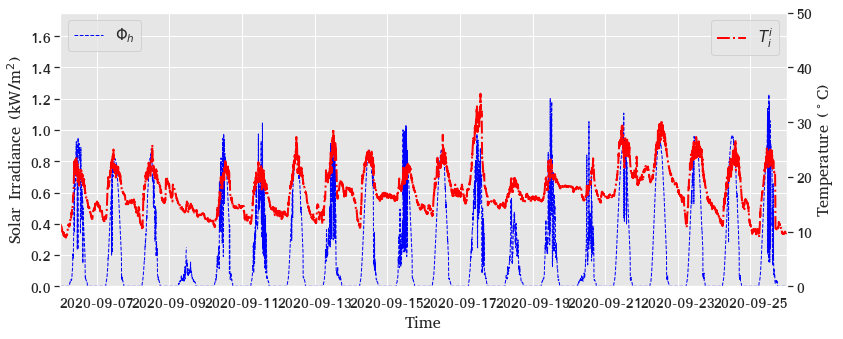

In [145]:
df_thermal = get_thermal(start_date, end_date)
plot_data(df_thermal, 'train')

# Testing Data

In [146]:
start_date = '2020-09-26'
end_date = '2020-10-03'

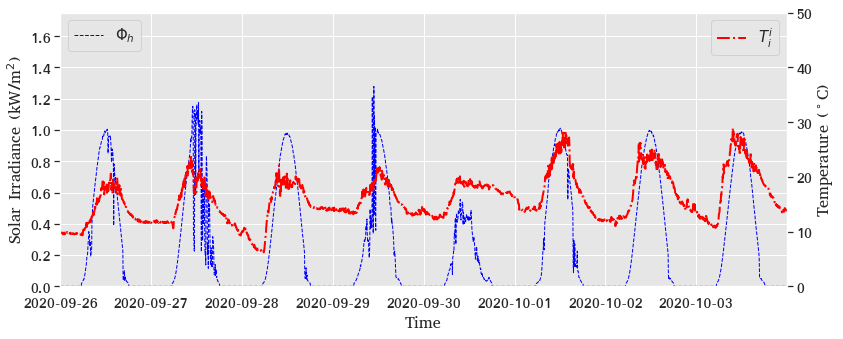

In [147]:
df_thermal = get_thermal(start_date, end_date)
plot_data(df_thermal, 'test')

In [148]:
mat_model = pd.read_csv('Tin_predict.csv')
mat_model = pd.to_numeric(mat_model['Model'])
mat_model.index = df_thermal.index

#Values duplicated in same cell of csv

In [149]:
df_thermal['mat'] = mat_model



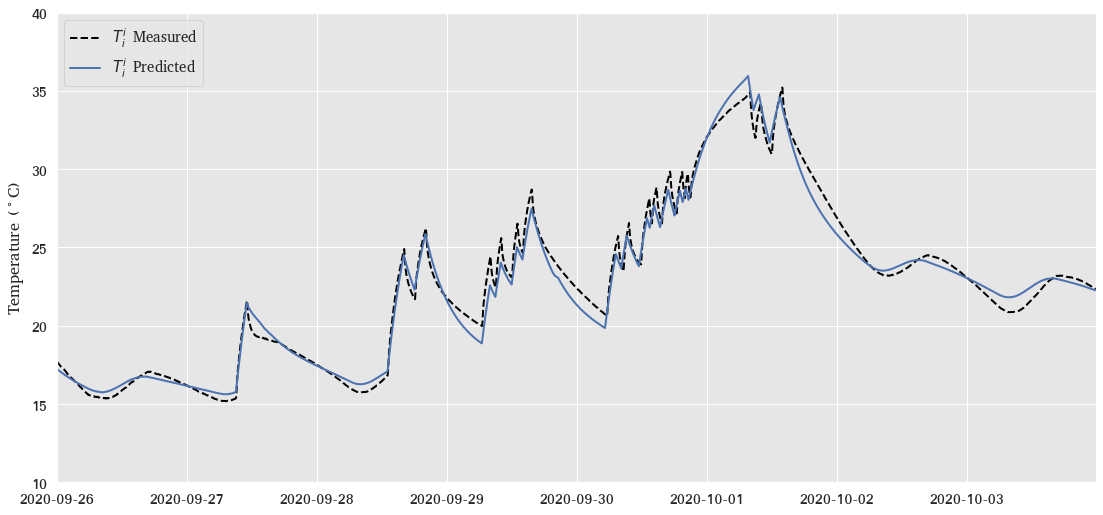

In [150]:
sns.set(font_scale=1.35)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
matplotlib.rcParams['font.family'] = 'Abyssinica SIL'

#Plot Results
fig, ax1 = plt.subplots()
ax1.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylim(10,40)
ax1.plot(df_thermal.index, df_thermal['t_av'], label='Temp Bed', lw=2, color='black', linestyle='--')
ax1.plot(df_thermal.index, df_thermal['mat'], label='Temp Bed', lw=2)
# ax2.plot(df_thermal['time_'], df_thermal['t_std'], label='Temp Bed', lw=3)
# ax2.plot(df_thermal['time_'], df_thermal['t_liv'], label='Temp Bed', lw=3)
# ax2.plot(df_thermal['time_'], df_thermal['t_din'], label='Temp Ext', lw=3)
ax1.set_xlim([df_thermal.index[0], df_thermal.index[-1:][0]])
ax1.legend(['$T_i^i$ Measured', '$T_i^i$ Predicted'], loc="upper left")

fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(16)# otherwise the right y-label is slightly clipped
#ax1.grid()
plt.savefig(f'pred_v_meas_data.pdf', bbox_inches='tight')
plt.show()

In [151]:
# start_date = '2020-11-28'
# end_date = '2020-11-29'
# df_thermal = get_thermal(start_date, end_date)
# plot_data(df_thermal, 'test')

In [152]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_thermal['t_av'],df_thermal['mat'])

In [153]:
r_value**2

0.9844763907507933

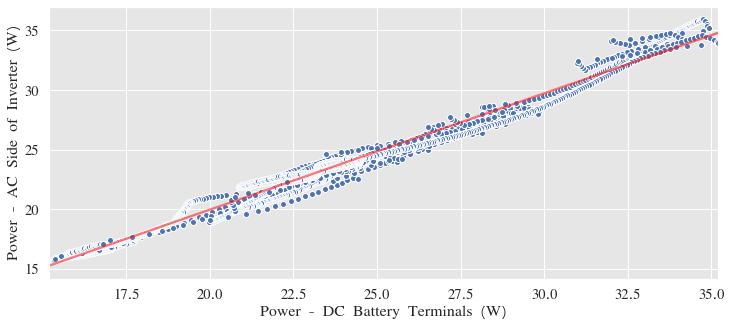

In [154]:
sns.set(font_scale=1.35, rc={'figure.figsize':(12,5)})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
matplotlib.rcParams['font.family'] = 'aakar'
ax = sns.regplot(x=df_thermal['t_av'], y=df_thermal['mat'],
           line_kws={"color": "red", "alpha":0.5},
           scatter_kws={"alpha":0.99, 'edgecolor':'white'})
ax.set(xlabel='Power - DC Battery Terminals (W)', ylabel='Power - AC Side of Inverter (W)')
#plt.savefig('dis_efficiency.pdf', bbox_inches='tight')
plt.show()

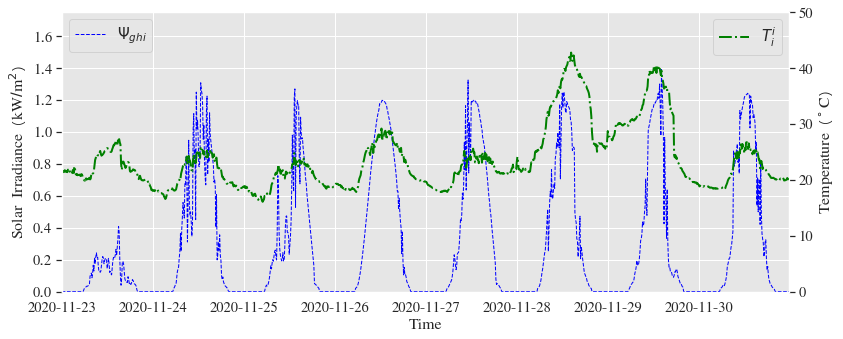

In [173]:
start_date = '2020-11-23'
end_date = '2020-11-30'
df_thermal = get_thermal(start_date, end_date)
df_thermal =df_thermal.resample('10min').mean().dropna()
#df_thermal['t_ext'] = df_thermal['t_ext'].ewm(span = 12).mean()
plot_data(df_thermal, 'single')